In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 30
DATASET_DIR = "hmdb51"
CLASSES_LIST = ["jump", "punch", "pushup", "pullup", "handstand"]

In [3]:
def frames_extraction(video_path):
    frames_list = []

    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 
        if not success:
            break
        
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    video_reader.release()
    return frames_list

In [6]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  
    
    return features, labels, video_files_paths

In [7]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: jump
Extracting Data of Class: punch
Extracting Data of Class: pushup
Extracting Data of Class: pullup
Extracting Data of Class: handstand


In [8]:
one_hot_encoded_labels = to_categorical(labels)

In [10]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.20, shuffle = True, random_state = seed_constant)

In [21]:
def plot_metric(model_training_history, metric1, metric2, plotName):
    
    val1 = model_training_history.history[metric1]
    val2 = model_training_history.history[metric2]
    
    epochs = range(len(val1))
 
    plt.plot(epochs, val1, 'crimson', label = metric1)
    plt.plot(epochs, val2, 'navy', label = metric2)
 
    plt.title(str(plotName))
    plt.legend()

In [13]:
from keras_self_attention import SeqSelfAttention

In [14]:
def LRACN_Model():
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
    
    model.add(SeqSelfAttention(attention_activation='softmax',name='Attention'))
    model.add(LSTM(32))                                  
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
    
    model.summary()
    return model

In [15]:
LRACN_model = LRACN_Model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 4, 4, 64)      1

In [16]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)
LRACN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
LRACN_model_training_history = LRACN_model.fit(x = features_train, y = labels_train, epochs = 150, batch_size = 10 ,
                                               shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/150
38/38 [==============================] - 26s 459ms/step - loss: 1.6312 - accuracy: 0.2558 - val_loss: 1.5933 - val_accuracy: 0.2872
Epoch 2/150
38/38 [==============================] - 17s 450ms/step - loss: 1.6030 - accuracy: 0.2674 - val_loss: 1.5878 - val_accuracy: 0.2021
Epoch 3/150
38/38 [==============================] - 16s 413ms/step - loss: 1.5202 - accuracy: 0.3410 - val_loss: 1.3419 - val_accuracy: 0.4681
Epoch 4/150
38/38 [==============================] - 15s 407ms/step - loss: 1.5616 - accuracy: 0.2966 - val_loss: 1.3935 - val_accuracy: 0.3617
Epoch 5/150
38/38 [==============================] - 15s 403ms/step - loss: 1.4152 - accuracy: 0.3367 - val_loss: 1.3262 - val_accuracy: 0.4574
Epoch 6/150
38/38 [==============================] - 17s 446ms/step - loss: 1.3125 - accuracy: 0.4392 - val_loss: 1.2956 - val_accuracy: 0.4255
Epoch 7/150
38/38 [==============================] - 17s 462ms/step - loss: 1.2986 - accuracy: 0.4635 - val_loss: 1.2261 - val_accuracy:

In [17]:
model_evaluation_history = LRACN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 3s 497ms/step - loss: 0.7182 - accuracy: 0.7712


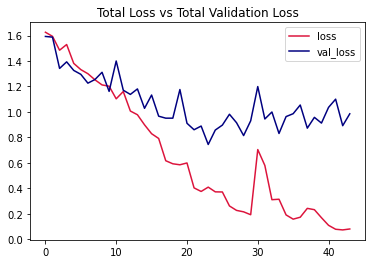

In [22]:
plot_metric(LRACN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

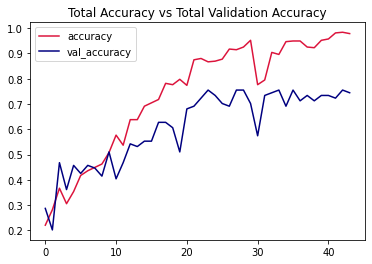

In [23]:
plot_metric(LRACN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [24]:
def LRACN_Model2():
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.20)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.20)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.20)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
    
    model.add(SeqSelfAttention(attention_activation='softmax',name='Attention'))
    model.add(LSTM(32))                                  
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
    
    model.summary()
    return model

In [25]:
LRACN_model2 = LRACN_Model2()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, 30, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_13 (TimeDis (None, 30, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 30, 4, 4, 64)     

In [26]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)
LRACN_model2.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
LRACN_model2_training_history = LRACN_model2.fit(x = features_train, y = labels_train, epochs = 150, batch_size = 10 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/150
38/38 [==============================] - 57s 1s/step - loss: 1.6160 - accuracy: 0.2340 - val_loss: 1.5997 - val_accuracy: 0.2766
Epoch 2/150
38/38 [==============================] - 20s 533ms/step - loss: 1.5883 - accuracy: 0.2727 - val_loss: 1.5174 - val_accuracy: 0.2021
Epoch 3/150
38/38 [==============================] - 20s 533ms/step - loss: 1.4148 - accuracy: 0.3613 - val_loss: 1.3142 - val_accuracy: 0.4574
Epoch 4/150
38/38 [==============================] - 21s 557ms/step - loss: 1.3615 - accuracy: 0.4097 - val_loss: 1.3291 - val_accuracy: 0.3723
Epoch 5/150
38/38 [==============================] - 21s 566ms/step - loss: 1.4164 - accuracy: 0.3875 - val_loss: 1.2960 - val_accuracy: 0.4149
Epoch 6/150
38/38 [==============================] - 21s 565ms/step - loss: 1.2906 - accuracy: 0.4480 - val_loss: 1.2166 - val_accuracy: 0.5426
Epoch 7/150
38/38 [==============================] - 22s 590ms/step - loss: 1.2689 - accuracy: 0.5142 - val_loss: 1.2643 - val_accuracy: 0.

In [45]:
model_evaluation_history = LRACN_model2.evaluate(features_test, labels_test)

4/4 [==============================] - 2s 471ms/step - loss: 0.5947 - accuracy: 0.8136


In [46]:
model2_evaluation_loss, model2_evaluation_accuracy = model_evaluation_history    
model2_file_name = f'LRACN__Loss_{model2_evaluation_loss}__Accuracy_{model2_evaluation_accuracy}.h5'
LRACN_model2.save(model2_file_name)

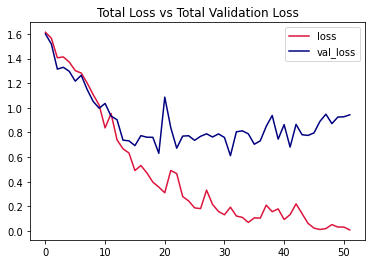

In [28]:
plot_metric(LRACN_model2_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

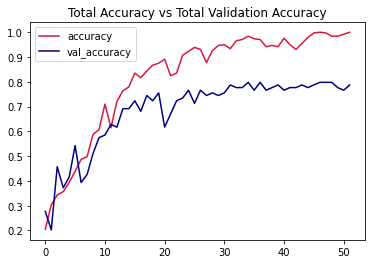

In [29]:
plot_metric(LRACN_model2_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [30]:
def LRACN_Model3():
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.15)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.15)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.15)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
    
    model.add(SeqSelfAttention(attention_activation='softmax',name='Attention'))
    model.add(LSTM(32))                                  
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
    
    model.summary()
    return model

In [31]:
LRACN_model3 = LRACN_Model3()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_24 (TimeDis (None, 30, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_25 (TimeDis (None, 30, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 30, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 30, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_28 (TimeDis (None, 30, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 30, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 30, 4, 4, 64)     

In [32]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)
LRACN_model3.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
LRACN_model3_training_history = LRACN_model3.fit(x = features_train, y = labels_train, epochs = 150, batch_size = 10 , 
                                                 shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/150
38/38 [==============================] - 91s 2s/step - loss: 1.6252 - accuracy: 0.2038 - val_loss: 1.6007 - val_accuracy: 0.2766
Epoch 2/150
38/38 [==============================] - 20s 519ms/step - loss: 1.5812 - accuracy: 0.2573 - val_loss: 1.4232 - val_accuracy: 0.3830
Epoch 3/150
38/38 [==============================] - 20s 525ms/step - loss: 1.3941 - accuracy: 0.4364 - val_loss: 1.2838 - val_accuracy: 0.4681
Epoch 4/150
38/38 [==============================] - 20s 519ms/step - loss: 1.3427 - accuracy: 0.3904 - val_loss: 1.2408 - val_accuracy: 0.4149
Epoch 5/150
38/38 [==============================] - 20s 528ms/step - loss: 1.3253 - accuracy: 0.4344 - val_loss: 1.2087 - val_accuracy: 0.4468
Epoch 6/150
38/38 [==============================] - 20s 523ms/step - loss: 1.1895 - accuracy: 0.5318 - val_loss: 1.2072 - val_accuracy: 0.4894
Epoch 7/150
38/38 [==============================] - 20s 516ms/step - loss: 1.1765 - accuracy: 0.4911 - val_loss: 1.1161 - val_accuracy: 0.

In [33]:
model3_evaluation_history = LRACN_model3.evaluate(features_test, labels_test)

4/4 [==============================] - 2s 493ms/step - loss: 0.5337 - accuracy: 0.8136


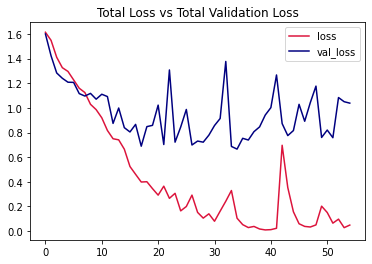

In [34]:
plot_metric(LRACN_model3_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

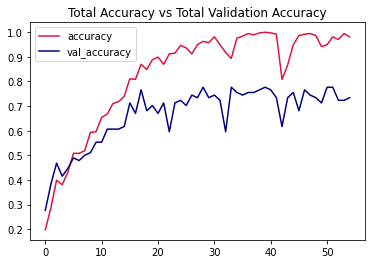

In [35]:
plot_metric(LRACN_model3_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [37]:
def LRACN_Model4():
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.20)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.15)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.10)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
    
    model.add(SeqSelfAttention(attention_activation='softmax',name='Attention'))
    model.add(LSTM(32))                                  
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
    
    model.summary()
    return model

In [38]:
LRACN_model4=LRACN_Model4()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_36 (TimeDis (None, 30, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 30, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 30, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 30, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_40 (TimeDis (None, 30, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_41 (TimeDis (None, 30, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 30, 4, 4, 64)     

In [39]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)
LRACN_model4.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
LRACN_model4_training_history = LRACN_model4.fit(x = features_train, y = labels_train, epochs = 150, batch_size = 10 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/150
38/38 [==============================] - 43s 837ms/step - loss: 1.6199 - accuracy: 0.2278 - val_loss: 1.6076 - val_accuracy: 0.2766
Epoch 2/150
38/38 [==============================] - 22s 584ms/step - loss: 1.5927 - accuracy: 0.2297 - val_loss: 1.5808 - val_accuracy: 0.3404
Epoch 3/150
38/38 [==============================] - 22s 581ms/step - loss: 1.5176 - accuracy: 0.3118 - val_loss: 1.3769 - val_accuracy: 0.4362
Epoch 4/150
38/38 [==============================] - 20s 533ms/step - loss: 1.3913 - accuracy: 0.3669 - val_loss: 1.2835 - val_accuracy: 0.3723
Epoch 5/150
38/38 [==============================] - 21s 553ms/step - loss: 1.3578 - accuracy: 0.3960 - val_loss: 1.2578 - val_accuracy: 0.4149
Epoch 6/150
38/38 [==============================] - 20s 540ms/step - loss: 1.2445 - accuracy: 0.4651 - val_loss: 1.1782 - val_accuracy: 0.5213
Epoch 7/150
38/38 [==============================] - 21s 556ms/step - loss: 1.1780 - accuracy: 0.5032 - val_loss: 1.0778 - val_accuracy:

In [40]:
model4_evaluation_history = LRACN_model4.evaluate(features_test, labels_test)

4/4 [==============================] - 3s 840ms/step - loss: 0.6585 - accuracy: 0.7373


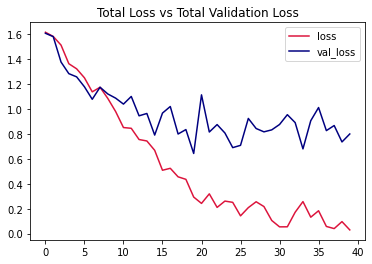

In [41]:
plot_metric(LRACN_model4_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

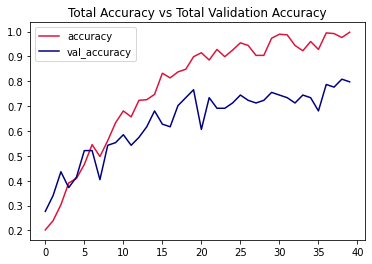

In [42]:
plot_metric(LRACN_model4_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')